# Get the vibe - Experimental Notebook

## Set up

### Imports

In [2]:
# General libraries
import numpy as np
import pandas as pd

# Image related
import matplotlib.pyplot as plt 
from matplotlib import image
from keras.preprocessing.image import load_img, img_to_array
import os

# CNN
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import Sequential, layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

# Confusion Matrix & Additional Metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

# Google Colab
#from google.colab import drive 

#### Set up

##### Data Augmentation Import

In [4]:
# Import data
image_df = pd.read_csv('../raw_data/NewAugmentedData3.csv')

In [5]:
image_df.head()

,emotion,pixels,Usage,std_dev
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training,50.735357
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training,40.854364
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training,74.711745
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training,59.357461
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training,70.166311


In [6]:
image_df.Usage.unique()

array(['Training', 'PublicTest', 'PrivateTest', 'DataAug'], dtype=object)

##### Show Images

In [13]:
# Define formate
FER2013_WIDTH = 48
FER2013_HEIGHT = 48

In [14]:
# Function showing picture
def show_image(index):
    """Shows the image and the emotion label of the index's instance."""
    image = aug_data.at[index, "pixels"].split(" ")
    image = np.reshape(image,(FER2013_WIDTH, FER2013_HEIGHT)).astype("float")
    print(Emotions[aug_data.at[index, "emotion"]])
    plt.imshow(image)

In [17]:
# Define Emotions
Emotions = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]  # indices 0 to 6

Angry


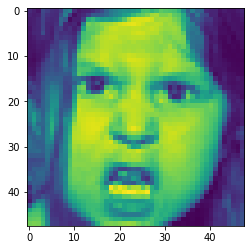

In [18]:
show_image(10000)

##### Emotions

In [7]:
# Define Emotions
Emotions = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]  # indices 0 to 6

In [8]:
# Insert column emotions
image_df["emotion_new"] = image_df["emotion"].map({0: "Angry", 1: "Disgust", 2: "Fear", 3: "Happy", 4: "Sad", 5: "Surprise", 6: "Neutral"})

## Preprosessing

### Exclude "disgust"

In [26]:
#image_df = image_df[image_df.emotion != 1]

### Training Data Split

In [18]:
train_set = image_df[(image_df.Usage == 'Training') | (image_df.Usage =='DataAug')] 
val_set = image_df[(image_df.Usage == 'PublicTest')]
test_set = image_df[(image_df.Usage == 'PrivateTest')] 

### Reshape X

In [21]:
# define x
X_train = np.array(list(map(str.split, train_set.pixels)), np.float32) 
X_val = np.array(list(map(str.split, val_set.pixels)), np.float32) 
X_test = np.array(list(map(str.split, test_set.pixels)), np.float32) 


X_train = X_train.reshape(X_train.shape[0], 48, 48, 1) 
X_val = X_val.reshape(X_val.shape[0], 48, 48, 1)
X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)

### Scaling 

In [22]:
X_train = (X_train/255) -0.5
X_val = (X_val/255) - 0.5
X_test = (X_test/255) - 0.5

### One hot encode y

In [23]:
# define y
y_train = train_set["emotion"]
y_val = val_set["emotion"]
y_test = test_set["emotion"]

In [24]:
y_test

32286    0
32287    5
32288    6
32289    4
32290    2
        ..
35870    6
35871    3
35872    0
35873    3
35874    2
Name: emotion, Length: 3589, dtype: int64

In [25]:
# One Hot Encode our Target for TensorFlow processing
from tensorflow.keras.utils import to_categorical

y_cat_train = to_categorical(y_train, num_classes=7)
y_cat_test = to_categorical(y_test, num_classes=7)
y_cat_val = to_categorical(y_val, num_classes=7)

## General Evaluation Functions

In [26]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label='train' + exp_name)
    ax1.plot(history.history['val_loss'], label='val' + exp_name)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    ax2.set_title('Accurary')
    ax2.legend()
    return (ax1, ax2)

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
"""
Displays a confusion matrix 
"""

def confusio(X_test, y_test, model):
    
    predicted_probabilities = model.predict(X_test)
    def prediction_from_probabilities(predicted_probabilities):
        return np.argmax(predicted_probabilities)
    y_pred = np.apply_along_axis(prediction_from_probabilities, 
                                 1,                            
                                 predicted_probabilities)
    
    
    labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'] # adapted to without "digust"
    cm = confusion_matrix(y_test, y_pred)
    cm = cm / cm.astype(np.float).sum(axis=1) # convert into percentages
    
    
    disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                              display_labels = labels);
    fig, ax = plt.subplots(figsize=(10,10));
    title='Confusion matrix'
    plt.title(title)
    disp.plot(cmap = "PuRd", ax = ax);
    pass

##  Model

### Cheeta model

#### Cheeta  model

In [ ]:
# Define regularizer
reg_l12 = regularizers.L1L2(l1=0.001, l2=0.001)

In [33]:
### 1. Architecture
model_insane = models.Sequential()

model_insane.add(layers.Conv2D(16, (6, 6), 
                 padding='same',
                 strides = (1,1),
                 input_shape=(48, 48, 1),
                 activation='relu',
                BatchNormalization())

model_insane.add(layers.MaxPooling2D(pool_size=(2, 2)))
model_insane.add(layers.Dropout(0.2))

model_insane.add(layers.Conv2D(32, (5, 5), padding='same', activation='relu'))
model_insane.add(layers.MaxPooling2D(pool_size=(2, 2)))
model_insane.add(layers.Dropout(0.2))

model_insane.add(layers.Conv2D(64, (4, 4), padding='same', activation='relu'))
model_insane.add(layers.MaxPooling2D(pool_size=(2, 2)))
model_insane.add(layers.Dropout(0.2))

model_insane.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
model_insane.add(layers.MaxPooling2D(pool_size=(2, 2)))
model_insane.add(layers.Dropout(0.2))

model_insane.add(layers.Flatten())
model_insane.add(layers.Dense(500, activation='relu'))
model_insane.add(layers.Dropout(0.3))
model_insane.add(layers.Dense(7, activation='softmax'))

model_insane.summary()

SyntaxError: invalid syntax (713950651.py, line 11)

In [29]:
#### 2. Compilation

model_insane.compile(loss='categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

In [30]:
#### 3. Fit
es = EarlyStopping(patience=15, restore_best_weights=True,)

history = model_insane.fit(X_train, y_cat_train,
                    epochs=150,
                    batch_size=32, 
                    verbose=1,
                    use_multiprocessing = True,
                    validation_data=(X_val,y_cat_val),
                    callbacks=[es]) 

Epoch 1/150
1651/1651 [==============================] - 170s 102ms/step - loss: 1.2819 - accuracy: 0.5023 - val_loss: 1.5715 - val_accuracy: 0.4103
Epoch 2/150
1651/1651 [==============================] - 148s 90ms/step - loss: 0.8760 - accuracy: 0.6680 - val_loss: 1.4249 - val_accuracy: 0.4652
Epoch 3/150
1651/1651 [==============================] - 146s 88ms/step - loss: 0.8040 - accuracy: 0.6955 - val_loss: 1.3458 - val_accuracy: 0.4894
Epoch 4/150
1651/1651 [==============================] - 154s 93ms/step - loss: 0.7611 - accuracy: 0.7124 - val_loss: 1.2814 - val_accuracy: 0.5128
Epoch 5/150
1651/1651 [==============================] - 148s 90ms/step - loss: 0.7330 - accuracy: 0.7195 - val_loss: 1.2564 - val_accuracy: 0.5234
Epoch 6/150
1651/1651 [==============================] - 168s 102ms/step - loss: 0.7111 - accuracy: 0.7308 - val_loss: 1.2471 - val_accuracy: 0.5151
Epoch 7/150
1651/1651 [==============================] - 175s 106ms/step - loss: 0.6952 - accuracy: 0.7366 - v

KeyboardInterrupt: 

In [ ]:
# Safe model
import joblib
from datetime import datetime

today = datetime.today()
joblib.dump(model_insane, 'drive/MyDrive/models/model_'+str(today)+'.joblib')

#### Evaluation

In [ ]:
# Evaluate model on the test data
print(model_insane.evaluate(X_test, y_cat_test, verbose=0))

In [ ]:
plot_history(history)

In [ ]:
from sklearn.metrics import classification_report

labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
predicted_probabilities = model_insane.predict(X_test)
def prediction_from_probabilities(predicted_probabilities):
    return np.argmax(predicted_probabilities)
y_pred = np.apply_along_axis(prediction_from_probabilities, 
                             1,                            
                             predicted_probabilities)

print(classification_report(y_test, y_pred, target_names=labels))

In [ ]:
confusio(X_test, y_test, model_insane)